# Making Your First Generative RNN in Pytorch

**Abhinav Madahar &middot; December 30, 2018**

You should read this if you know how to make and use a recurrent neural network, like an LSTM or a GRU.

Most models in machine learning are classifiers or regressors.
Classifiers read some data and give a label, like looking at an image of a pet to classify it as a dog or a cat.
Regressors read some data to spit out a number, like looking at a person to calculate their age.
Generative models are neither.
They read some data and *make more data*, like looking at a bunch of cats and then making new photos of cats.
This is very difficult, so we will start with a very simple goal: look at a linear gradient and extend it.

In this lesson, we will:

1. make a dataset of spectra,
2. make a model which predicts the next pixel given a current one,
3. train the model on the dataset,
4. see the model's output.

To start, let's import a few packages.

In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim

Our dataset is very easy to generate, and we can preview the first few lines.

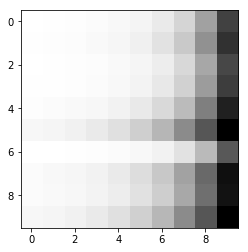

In [2]:
size_of_dataset = 10000
length_of_spectrum = 10

dataset = []
for _ in range(size_of_dataset):
    principal = random.random()
    rate = random.random() + 1
    maximum = principal * rate ** length_of_spectrum  # to normalise the line
    dataset.append([(principal * rate ** i) / maximum for i in range(length_of_spectrum)])
dataset = np.array(dataset)

plt.imshow(dataset[:10], cmap='Greys');

Now, we can create the model itself, made of a GRU followed by a linear layer.

In [3]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, batch_size, output_dim, num_layers):
        super(GRUModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.output_dim = output_dim
        
        self.gru = nn.GRU(self.input_dim, self.hidden_dim, self.num_layers)
        self.linear = nn.Linear(self.hidden_dim, self.output_dim)
        
    def forward(self, input_sequence):
        out, hidden = self.gru(input_sequence)
        pred = self.linear(out[-1])
        return pred

Now, we can train the model.

In [5]:
%%time

batch_size = 100
hidden_dim = 8

sequence_length = 3
model = GRUModel(input_dim=sequence_length, hidden_dim=hidden_dim, batch_size=batch_size, output_dim=1, num_layers=1)

criterion = nn.MSELoss()
optimiser = optim.SGD(model.parameters(), lr=0.0001)
losses = []

n_epochs = 100

for epoch in range(n_epochs):
    np.random.shuffle(dataset)

    batches = []
    batch = []
    for line in dataset:
        batch.append(line)
        if len(batch) == batch_size:
            batches.append(batch)
            batch = []
    batches = np.array(batches).reshape(-1, batch_size, 10, 1)
    batches = np.swapaxes(batches, 1, 2)

    epoch_loss = 0
    for batch in batches:
        x = [list(zip(*(np.roll(batch[:, row, 0], -offset)[:-(sequence_length+1)] for offset in range(sequence_length)))) for row in range(batch_size)]
        x = sum(x, [])
        x = np.array(list(x)).reshape(1, -1, sequence_length)
        y = np.roll(batch[:, 0, 0], -sequence_length)[:-sequence_length]
        x, y = torch.from_numpy(x), torch.from_numpy(y)
        x, y = x.float(), y.float()
        model.zero_grad()
        gru_out = model(x)
        loss = criterion(gru_out, y)
        loss.backward()
        optimiser.step()
        epoch_loss += loss
    losses.append(float(epoch_loss))
    print(epoch, '(loss={})'.format(epoch_loss))

0 (loss=60.66951370239258)
1 (loss=60.843231201171875)
2 (loss=63.894927978515625)
3 (loss=59.44229507446289)
4 (loss=54.062042236328125)
5 (loss=51.24949264526367)
6 (loss=50.41819381713867)
7 (loss=52.54805374145508)
8 (loss=45.711063385009766)
9 (loss=48.51734924316406)
10 (loss=45.17933654785156)
11 (loss=46.3193359375)
12 (loss=41.43000793457031)
13 (loss=41.01415252685547)
14 (loss=38.665279388427734)
15 (loss=41.135013580322266)
16 (loss=31.342227935791016)
17 (loss=33.869834899902344)
18 (loss=34.356056213378906)
19 (loss=33.06422424316406)
20 (loss=27.726890563964844)
21 (loss=27.328542709350586)
22 (loss=32.118194580078125)
23 (loss=24.75952911376953)
24 (loss=24.4255313873291)
25 (loss=24.75432777404785)
26 (loss=26.959739685058594)
27 (loss=25.5402889251709)
28 (loss=22.468420028686523)
29 (loss=23.68446922302246)
30 (loss=23.919294357299805)
31 (loss=21.4263973236084)
32 (loss=19.208831787109375)
33 (loss=21.721092224121094)
34 (loss=20.815044403076172)
35 (loss=22.7670097

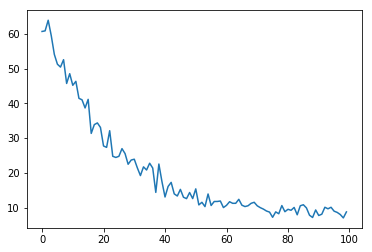

In [6]:
plt.plot(losses)

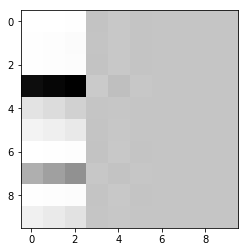

In [13]:
np.random.shuffle(dataset)
initial_pixels = torch.from_numpy(dataset[:10, 0:sequence_length]).reshape(1, 10, -1).float()

reconstruction = initial_pixels.detach().numpy()
for i in range(10-sequence_length):
    reconstruction = torch.from_numpy(reconstruction)
    column = model(reconstruction[:, :, i:]).detach().numpy()
    reconstruction = np.concatenate([reconstruction[0], column], axis=1).reshape(1, 10, -1)
    
reconstruction = reconstruction.reshape(10, -1)

plt.imshow(reconstruction, cmap='Greys');